In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import KFold
from sklearn.metrics import auc
from sklearn import metrics

In [4]:
reader = Reader(sep=',', rating_scale=(0.0, 5.0), skip_lines=1)
df = pd.read_csv('ml-latest-small/ratings.csv', names = ['userId', 'itemId', 'rating', 'timestamp'],header=0)
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)

# Questions 17-18: NNMF Collaborative Filter

In [3]:
def GetDataframe():
    df = pd.read_csv("ml-latest-small/ratings.csv")
    df.drop('timestamp', axis=1, inplace=True)
    num_users = df.userId.unique().shape[0]
    num_items = df.movieId.unique().shape[0]

    print('Number of users: %d, number of items: %d.' % (num_users, num_items))
    return df, num_users, num_items

def GetRMatrix(data):
    X = data.values
    users = X[:,0]
    movies = X[:,1]

    movie_map = {}
    reverse_movie_map = {}
    new_id = 0
    for idx in range(len(movies)):
        item = int(movies[idx])
        if item not in movie_map:
            movie_map[item] = new_id
            reverse_movie_map[new_id] = item
            new_id += 1

    ratings = X[:,2]
    num_ratings = int(len(ratings))
    R = np.zeros((num_users, num_items))

    for i in np.arange(num_ratings):
        R[int(users[i]-1), movie_map[movies[i]]] = ratings[i]
        
    return R, users, movies, ratings, movie_map, reverse_movie_map

df, num_users, num_items = GetDataframe()
R, users, movies, ratings, movie_map, reverse_movie_map = GetRMatrix(df)

Number of users: 610, number of items: 9724.


In [4]:
def model_Error_Sweep(data, plotName, biased = False, ks = range(2, 52, 2), cv=10):
    mae, rmse = [0] * len(ks), [0] * len(ks)
    for i, k in enumerate(ks):
        model = NMF(n_factors=k, biased=biased)
        scores = cross_validate(model, data, cv=cv, n_jobs=-1)
        mae[i] = scores['test_mae'].mean()
        rmse[i] = scores['test_rmse'].mean()
    plt.figure(figsize=(10,10))
    plt.subplot(2, 1, 1)
    plt.plot(ks, mae)
    plt.title('Mean Absolute Error (MAE) vs. k of ' + plotName)
    plt.xlabel('k')
    plt.ylabel('MAE')
    plt.subplot(2, 1, 2)
    plt.plot(ks, rmse)
    plt.title('Root Mean Squared Error (RMSE) vs. k of ' + plotName)
    plt.xlabel('k')
    plt.ylabel('RMSE')
    return ks, mae, rmse


For NNMF model:
Min RSME: 0.8664105566972014 at k = 2
Min MAE: 0.6629046979809626 at k = 2


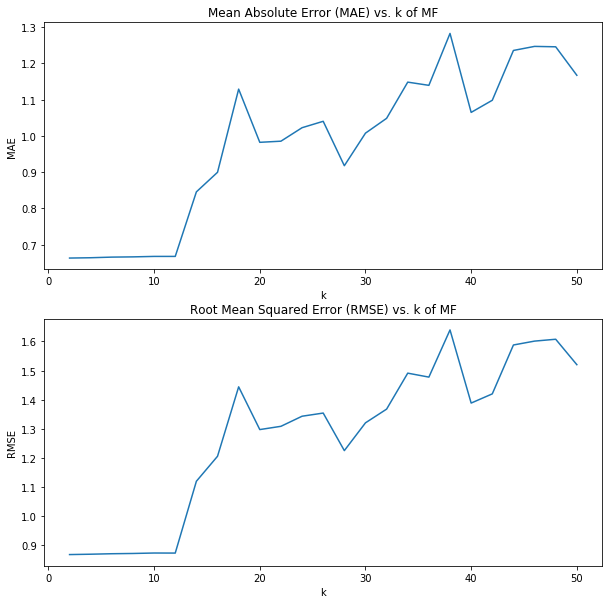

In [5]:
[ks_NNMF, mae_NNMF, rmse_NNMF] = model_Error_Sweep(data, "MF", biased =True, ks = range(2, 52, 2), cv=10)
print('For NNMF model:')
print('Min RSME: {} at k = {}'.format(np.min(rmse_NNMF), ks_NNMF[np.argmin(rmse_NNMF)]))
print('Min MAE: {} at k = {}'.format(np.min(mae_NNMF), ks_NNMF[np.argmin(mae_NNMF)]))

# Questions 19-21: NNMF Filter with Trimming

In [6]:
def GetMovieStats(R):
    is_rated = R!=0
    rat_per_movie = np.sum(is_rated, axis=0)

    nanR = R.copy()
    nanR[nanR == 0] = np.nan
    var_per_movie = np.nanvar(nanR, axis=0)
    return rat_per_movie, var_per_movie

def TrimPopular(testset, rat_per_movie, movie_map):
    res = []
    for item in testset:
        if rat_per_movie[movie_map[item[1]]] > 2:
            res.append(item)
            
    return res

def TrimUnpopular(testset, rat_per_movie, movie_map):
    res = []
    for item in testset:
        if rat_per_movie[movie_map[item[1]]] <= 2:
            res.append(item)
            
    return res

def TrimVariance(testset, rat_per_movie, var_per_movie, movie_map):
    res = []
    for item in testset:
        if rat_per_movie[movie_map[item[1]]] >= 5 and var_per_movie[movie_map[item[1]]] >= 2:
            res.append(item)
            
    return res


def GetTrimResults(model_func, data, R):
    rat_per_movie, var_per_movie = GetMovieStats(R)

    kf = KFold(n_splits=10)

    ks = np.arange(2, 102, 2)
    rmse = np.zeros((len(ks), 3))
    for idx, k in enumerate(ks):
        algo = model_func(k)

        for trainset, testset in kf.split(data):
            algo.fit(trainset)

            popular_testset = TrimPopular(testset, rat_per_movie, movie_map)
            unpopular_testset = TrimUnpopular(testset, rat_per_movie, movie_map)
            var_testset = TrimVariance(testset, rat_per_movie, var_per_movie, movie_map)

            predictions = algo.test(popular_testset)
            rmse[idx, 0] += accuracy.rmse(predictions, verbose=False)

            predictions = algo.test(unpopular_testset)
            rmse[idx, 1] += accuracy.rmse(predictions, verbose=False)

            predictions = algo.test(var_testset)
            rmse[idx, 2] += accuracy.rmse(predictions, verbose=False)

    rmse /= 10

    test_names = ["popular", "unpopular", "high variance"]
    for i in range(3):
        plt.plot(ks, rmse[:, i])
        plt.title("NNMF: RMSE vs k for {} testset".format(test_names[i]))
        plt.ylabel("Average RMSE")
        plt.xlabel("k")
        plt.show()
        print('For NNMF model for {}:'.format(test_names[i]))
        print('Min RSME: {} at k = {}'.format(np.min(rmse[:, i]), ks[np.argmin(rmse[:, i])]))
    return ks, rmse



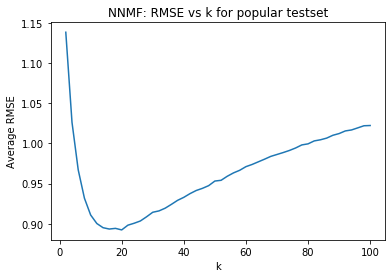

For NNMF model for popular:
Min RSME: 0.8925030657504825 at k = 20


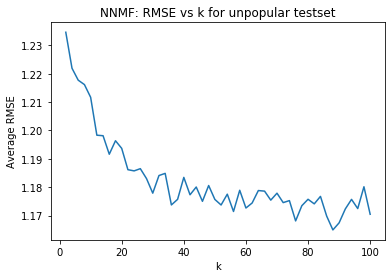

For NNMF model for unpopular:
Min RSME: 1.1649398518142164 at k = 88


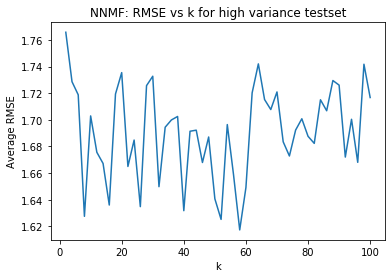

For NNMF model for high variance:
Min RSME: 1.6172807391613204 at k = 58


In [7]:
model_func = lambda x : NMF(n_factors=x, biased=False)
[ks, rmse] = GetTrimResults(model_func, data, R)

# Questions 22: NNMF ROC with Varying Thresholds

In [53]:
def plot_roc(fpr, tpr, title):
    fig, ax = plt.subplots()
    roc_auc = auc(fpr,tpr)
    ax.plot(fpr, tpr, lw=2, label = 'Area Under Curve = %0.4f' % roc_auc)
    ax.grid(color = '0.7', linestyle = '--', linewidth=1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title(title)
    ax.legend(loc = "lower right")
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(15)

In [54]:
def plot_roc_for_thresholds(biased=False, bestLF = 20, thresholds = np.arange(2.5,4.5,.5)):
    label_names = ['userId', 'itemId', 'rating', 'timestamp']
    df = pd.read_csv('ml-latest-small/ratings.csv', names = label_names, header=0)
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)
    fpr_all = []
    tpr_all = []
    for idx, threshold in enumerate(thresholds):
        train_set, test_set = train_test_split(data, test_size=0.1)
        algo = NMF(n_factors=bestLF, biased=biased)
        algo.fit(train_set)
        predictions = algo.test(test_set)
        trues = [0 if getattr(row, 'r_ui') < threshold else 1 for row in predictions]
        scores = [getattr(row, 'est') for row in predictions]
        fpr, tpr, _ = metrics.roc_curve(trues, scores)
        roc_auc = metrics.auc(fpr, tpr)
        name = 'ROC of NNMF with threshold = %.1f' % threshold
        plot_roc(fpr,tpr, name)
        fpr_all.append(fpr)
        tpr_all.append(tpr)
        if idx==0:
            best_threshold = threshold
            best_AUC = roc_auc
        elif best_AUC < roc_auc:
            best_threshold = threshold
            best_AUC = roc_auc
    return fpr_all, tpr_all, best_threshold

3.0


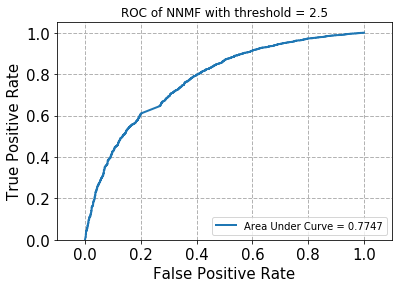

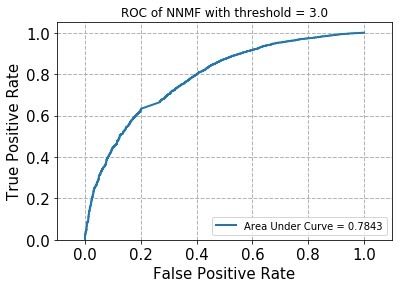

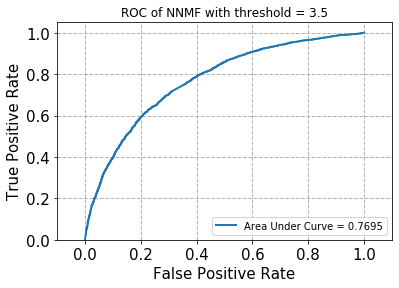

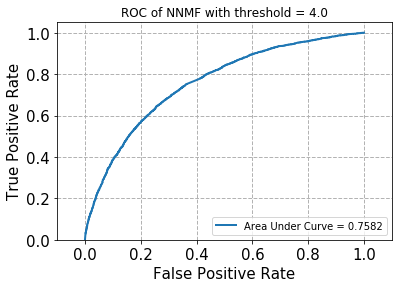

In [55]:
MMF_fpr_all, MMF_tpr_all, MMF_best_threshold = plot_roc_for_thresholds(biased=False, bestLF = 20, thresholds = np.arange(2.5,4.5,.5))
print(MMF_best_threshold)

# Questions 23: NNMF Filter Top 10 Movie Genres

In [8]:
df2 = pd.read_csv('ml-latest-small/movies.csv', names = ['movieid', 'title', 'genres'],header=0)
train_set = data.build_full_trainset()
algo = NMF(n_factors=20, biased=False, random_state = 0)
algo.fit(train_set)
V = algo.qi
for col in range(0,20):
    Movies_in_col = V[:,col]
    moviesSorted = []
    for i in range(len(Movies_in_col)):
        moviesSorted.append((i, Movies_in_col[i]))
    moviesSorted.sort(key = lambda x:x[1], reverse=True)
    print("   ")
    print ("for Column = ", col)
    for mt in moviesSorted[0:10]:
        print (df2['genres'][mt[0]])
    print("   ")

   
for Column =  0
Comedy|Drama|Romance
Horror|Sci-Fi
Crime|Drama|Musical
Comedy|Drama|Romance
Drama|Romance
Comedy
Drama|Mystery|Sci-Fi|Thriller
Drama
Drama
Drama|Thriller|War
   
   
for Column =  1
Drama|Western
Drama|Musical
Film-Noir|Thriller
Comedy
Comedy|Romance
Comedy
Action|Comedy
Action|Crime|Thriller
Horror|Sci-Fi|Thriller
Children|Comedy
   
   
for Column =  2
Comedy|Drama|Romance
Horror|Thriller
Drama
Drama|Romance
Adventure|Children
Drama|Romance
Drama
Crime|Drama|Film-Noir|Thriller
Drama
Adventure|Children|Comedy|Mystery
   
   
for Column =  3
Drama
Children|Drama
Thriller
Action|Adventure|Fantasy|Sci-Fi
Comedy|Romance
Comedy
Action|Adventure|Comedy
Documentary
Comedy|Crime
Comedy|Romance
   
   
for Column =  4
Drama
Horror|Thriller
Drama
Action|Comedy|Sci-Fi
Comedy
Drama
Drama
Comedy
Comedy|Drama|Thriller
Crime|Drama
   
   
for Column =  5
Documentary
Comedy
Comedy|Drama|Romance
Horror
Adventure|Animation|Children|Comedy
Drama
Comedy|Drama
Crime|Fantasy|Horror
Come

# Questions 24-25: MF Collaborative Filter

For MF model:
Min RSME: 0.8664105566972014 at k = 2
Min MAE: 0.6629046979809626 at k = 2


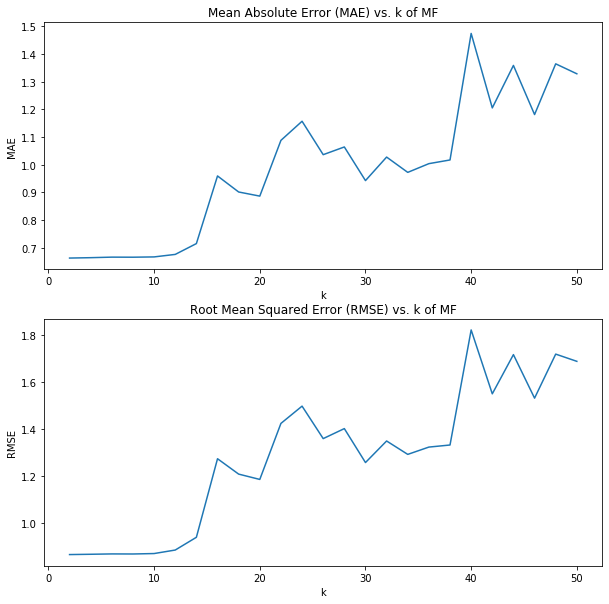

In [57]:
[ks_SVD, mae_SVD, rmse_SVD] = model_Error_Sweep(data, "MF", biased = True, ks = range(2, 52, 2), cv=10)
print('For MF model:')
print('Min RSME: {} at k = {}'.format(np.min(rmse_NNMF), ks_NNMF[np.argmin(rmse_NNMF)]))
print('Min MAE: {} at k = {}'.format(np.min(mae_NNMF), ks_NNMF[np.argmin(mae_NNMF)]))

# Questions 26-28: MF Filter with Trimming

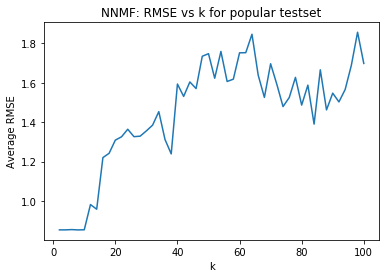

For NNMF model for popular:
Min RSME: 0.8530901200491886 at k = 8


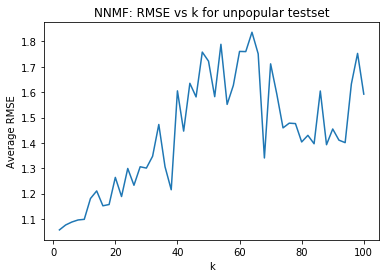

For NNMF model for unpopular:
Min RSME: 1.0570045103442027 at k = 2


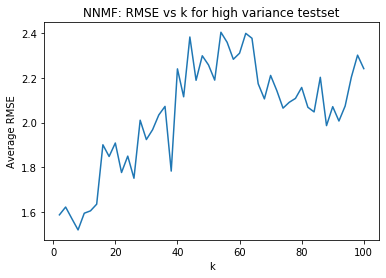

For NNMF model for high variance:
Min RSME: 1.5189889657941271 at k = 8


(array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
         28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
         54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
         80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100]),
 array([[0.85327168, 1.05700451, 1.58646484],
        [0.85337496, 1.07645544, 1.62149764],
        [0.8547079 , 1.08811847, 1.56967522],
        [0.85309012, 1.09624475, 1.51898897],
        [0.8537939 , 1.09870216, 1.59376345],
        [0.98178224, 1.18083893, 1.60438433],
        [0.95803453, 1.21077137, 1.63438211],
        [1.21987726, 1.15207194, 1.90044846],
        [1.24184192, 1.1571749 , 1.84802631],
        [1.30861085, 1.26408945, 1.90830583],
        [1.32555547, 1.18863914, 1.77615648],
        [1.36383436, 1.29930457, 1.84960158],
        [1.32617675, 1.2330415 , 1.75052194],
        [1.32879259, 1.30602708, 2.01041985],
        [1.35560664, 1.30081418, 1.92380889],
        [1.38461278, 1.347

In [58]:
model_func = lambda x : NMF(n_factors=x, biased=True)
GetTrimResults(model_func, data, R)

# Questions 29: MF ROC with Varying Thresholds

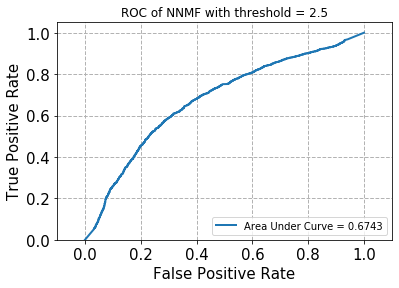

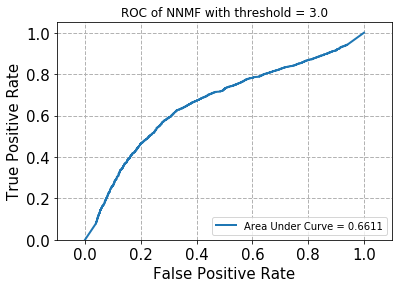

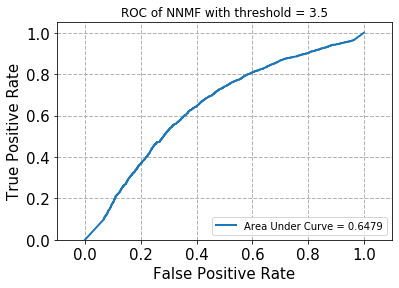

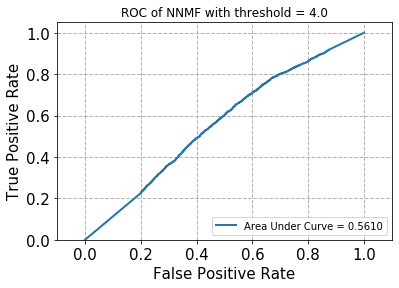

In [59]:
MF_fpr_all, MF_tpr_all, MF_best_threshold = plot_roc_for_thresholds(biased=True, bestLF = 20, thresholds = np.arange(2.5,4.5,.5))